In [1]:
# Run this first!!!

from __future__ import division
import matplotlib.pyplot as plt
from scipy.optimize import brentq

import sys
sys.path.append('..')
import util
sys.path.append('../aho_merging')
from size_model import SizeModel
sys.path.append('../common')
import common_probs

# A Model for Number of States

### Overview of Model

At this point I would like to come up with a model for describing the number of states necessary for a minimal DFA given a random generalized string. I attempted this problem briefly before, but did not make any progress because there were too many factors. However, this time I realized rather than modelling the number of states directly we can use the number of suffixes that match with a prefix in a level as a proxy. Knowing this tells us approximately how many unique failure transitions there are which tells us how many states are in the level.

For ease of description I have been using the term "thread" to describe a single suffix that grows as we go do deeper in levels. Note then that this thread can be terminated if in the next level we find that we cannot add on to the suffix to make it a prefix of the generalized string. Likewise, the thread can split into two seperate threads if we find that in the automaton the children of the corresponding state have two unique failure links. Also note that for every level we can begin one new thread besides a split (because there is only one state in level 1). Our goal is now to find how many threads are in each level of the automaton.

Note that this closely resembles the Galton-Watson process because we can think of these threads having offspring. The only slight difference is that for every generation one new child can appear from nowhere. Therefore I pursue this model to see if it has any explanatory power.

### Details of Model

Let $Z_n$ be a stochastic process such that $Z_n$ is the number of threads that are present in level $n$. Furthermore, let $F$ be the offspring distribution and let $Y_{i, j}$ be iid draws from this distribution. Lastly, let $X_n$ be the random variable that takes on the value 1 if there is a new thread in level $n$ and 0 otherwise. For simplicity sake we will first assume that the $X_n$s are iid.

Then we note that...

$$
Z_{n + 1} = X_{n + 1} + \sum_{j = 1}^{Z_n} Y_{n+1, j}
$$

From this we can compute the expected value at each level where $E[X_n] = \mu_X$ and $E[Y_{i, j}] = \mu_Y$...

$$
E[Z_{n + 1}] = \mu_X + E\left[\sum_{m = 1}^\infty \sum_{j = 1}^m Y_{n + 1, j} 1[Z_n = m]\right]
$$

$$
= \mu_X + \sum_{m = 1}^\infty \sum_{j = 1}^m E[Y_{n + 1, j}] P(Z_n = m)
$$

$$
= \mu_X + \mu_Y \sum_{m = 1}^\infty m P(Z_n = m) = \mu_X + \mu_Y E[Z_n]
$$

Using the initial condition of $E[Z_1] = 0$ and $E[Z_2] = \mu_X$...

$$
E[Z_n] = \mu_X \sum_{j = 1}^{n - 2} \mu_Y^j
$$

For integer values of $n \geq 3$.

Lastly note that if $\mu_Y < 1$ then

$$
\lim_{n \rightarrow \infty} E[Z_n] = \frac{\mu_X}{1 - \mu_Y}
$$

Otherwise the limit does not exist.

### Evaluating Uesfulness of Model

The hard part now becomes trying to find the appropriate distributions for the given values. For now the only key part of this is having $\mu_Y < 1$ so that the expected value converges to some limit. However, for now I will just do simulations with more or less arbitrary distributions. The goal of these simulations is to see if the trend is similar to what we observe when we actually simulate the number of states for the automata. The resuls of this are shown below.

In [27]:
def analyze(alph_size, num_levels, trials, new_thread_prob = None, offspring_dist = None):
    if new_thread_prob is None or offspring_dist is None:
        new_thread_prob, offspring_dist = _determine_params(alph_size)
    model = SizeModel(new_thread_prob, offspring_dist)
    average_trend = model.do_sims(num_levels, trials)
    single_trend = model.do_sims(num_levels, 1)
    print 'New Thread Mean: %f' % new_thread_prob
    offspring_mean = model.get_offspring_mean()
    print 'Offspring Mean: %f' % offspring_mean
    asym_state_mean = model.get_asymptotic_state_mean()
    print 'Asymptotic State Mean: %f' % asym_state_mean
    x_axis = range(1, num_levels + 1)
    plt.plot(x_axis, average_trend, 'b', label='Average Trend')
    plt.plot(x_axis, single_trend, 'r', label='Single Trend')
    plt.axhline(asym_state_mean, color='k', label='Asymptotic Average')
    plt.legend(loc='upper right')
    plt.show()

def _determine_params(alph_size):
    new_thread_prob = 1 / alph_size
    offspring_dist = [0 for _ in range(alph_size + 1)]
    c_2 = common_probs.get_c2(alph_size)
    offspring_dist[0] = 1 - c_2
    root_eqn = lambda x: sum([x ** (3 ** i) for i in range(alph_size)]) - c_2
    prob_piece = brentq(root_eqn, 0, 1)
    for index in range(1, alph_size + 1):
        offspring_dist[index] = prob_piece ** (3 ** (index - 1))
    return (new_thread_prob, offspring_dist)

New Thread Mean: 0.250000
Offspring Mean: 0.984977
Asymptotic State Mean: 16.640612


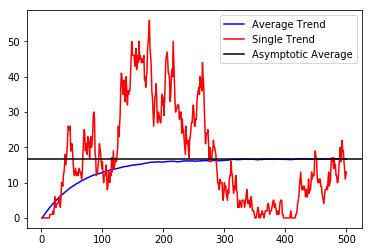

In [36]:
# Constants
ALPHABET_SIZE = 4
NUMBER_OF_LEVELS = 500
TRIALS = 10000

analyze(ALPHABET_SIZE, NUMBER_OF_LEVELS, TRIALS)

This is promising because the average trend looks pretty similar to the average trend of the simulations that were done before. Next time we will hopefully try to find probabilities close to this and compare to actual simulation.